# Dynamic Programming for Reinforcement Learning

This notebook tries out the concepts explained in Chapter 4 of the book [Reinforcement Learning: An Introduction - Sutton & Barto](https://www.goodreads.com/book/show/739791.Reinforcement_Learning). 

This is **not Reinforcement Learning**, really: it **assumes perfect knowledge of the world model** and based on that computes a solution, even though an approximate one, in the case of this notebook. 

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def draw_grid(value): 
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.axis('tight')
    ax.axis('off')
    
    # Round values to 2 decimal places for display
    rounded_value = np.round(value, 2)
    
    # Create table
    table = ax.table(cellText=rounded_value, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(2, 2)
    
    # Style the cells
    for i in range(len(value)):
        for j in range(len(value[0])):
            cell = table[(i, j)]
            cell.set_facecolor('#f0f0f0')
            cell.set_edgecolor('black')
            cell.set_linewidth(1)
    
    plt.show()

The initialization of the state values just sets them all to zeroes. It can be any arbitrary value, but the target states have to be zeros. 

In [75]:
def init_value_function(grid_size):
    """Initialize the value function to all zeros for every cell"""
    value_function = np.zeros(grid_size)
    return value_function

## The world model
The world model is the one described in Chapter 4 of the book. <br>
It is again important to notice that this algorithm **only works because we know the world model**: 
* we must know the probability distributions of the rewards and of the actions
* we must know what states there are and how they are linked (in this case there's no probabilistic approach to switching state)

The following model:
* Assumes a grid.
* The grid has two target states (with value 0): top left and bottom right corner. 
* Moving into any non target state yields a reward of -1 .
* Moving into a target state yields a reward of 0 .
* Actions to move from a cell to another are just the four actions "up", "down", "left" and "right"

In [ ]:
from typing import Tuple


def get_next_state(state, action, grid_size):
    """Get the next state given the current state and action"""
    x, y = state
    if action == 'up' and x > 0:
        x -= 1
    elif action == 'down' and x < grid_size[0] - 1:
        x += 1
    elif action == 'left' and y > 0:
        y -= 1
    elif action == 'right' and y < grid_size[1] - 1:
        y += 1
    return (x, y)

def get_reward(state, grid_size) -> Tuple[int, int]:
    """Get the reward for moving to a state
    
    Returns 0 if the state is one of the target states, else -1.
    Target States are hard coded: they are (0, 0) and (grid_size[0]-1, grid_size[1]-1)
    
    Args: 
        state: tuple (x, y) representing the current state
        grid_size: tuple (rows, cols) representing the size of the grid
        
    Returns:
        A tuple (probability of the reward, reward value)
    """
    return (1, 0 if state in [(0, 0), (grid_size[0]-1, grid_size[1]-1)] else -1)

State values are calculated according to the Bellman equation. 

In [63]:
def state_value_k(state, values_km1, policy, grid_size, gamma): 
    """Calculates the value of the state at iteration k under the policy
    
    Args:
        state: current state indicated as a tuple (row, column)
        values_km1: value function at iteration k-1
        policy: policy matrix indicating action probabilities for each state. It's a 4x4x4 matrix
        grid_size: tuple (rows, cols) representing the size of the grid
        gamma: discount factor
    """
    # value of a terminal state is always 0
    if state in [(0, 0), (grid_size[0]-1, grid_size[1]-1)]:
        return 0
    
    # For each action, multiply the probability of taking that action by the value of choosing that action in the state
    action_values = []
    for (action_i, action) in enumerate(['up', 'down', 'left', 'right']):
        action_prob = policy[state[0]][state[1]][action_i]
        
        # For each state reachable from the current state with that action, get the value
        next_state = get_next_state(state, action, grid_size)
        (reward_prob, reward) = get_reward(next_state, grid_size) # Reward is a tuple (probability, value of reward)
        next_state_value = values_km1[next_state[0]][next_state[1]]
        
        value = action_prob * reward_prob * (reward + gamma * next_state_value)
        
        action_values.append(value)
        
    return sum(action_values)
    

In [76]:
def iterative_policy_eval(policy, grid_size, gamma, max_iterations=10): 
    """Evaluates the given policy on all the states. 
    Each cell in the grid represents in the state. 
    The value in the cell represents the value of that state under the provided policy.
    
    Utilizes DP to compute appximate the value function using the Bellman expectation equation and iterative updates.
    
    Args:
        policy: The policy function to eval
        grid_size: the grid_size as a tuple (rows, cols)
        gamma: Discount factor for future rewards.
    """
    k = 1  # iteration counter. k = 0 is the initialization step (states provided)
    max_k = max_iterations
    
    initial_states = init_value_function(grid_size)
    
    state_values = np.zeros((max_k, grid_size[0], grid_size[1]))
    state_values[0] = initial_states
    
    while k < max_k: 
        for state_i in range(grid_size[0]):
            for state_j in range(grid_size[1]):
                state = (state_i, state_j)
                svk = state_value_k(state, state_values[k-1], policy=policy, grid_size=grid_size, gamma=gamma)
                
                state_values[k][state_i][state_j] = svk
        
        k += 1
    
    return state_values

        
    

## Run the Algo

We can see that the value function does not really change after iteration 50: it has **converged**. 

What does this value function represent? <br>
> It is the **value function of the policy** that is determined by assigning an equal probability to each action. 

Value function at iteration 0:


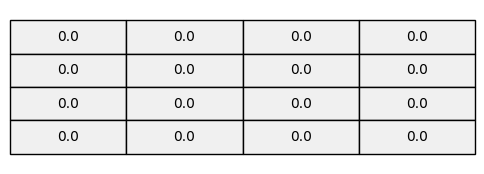

Value function at iteration 5:


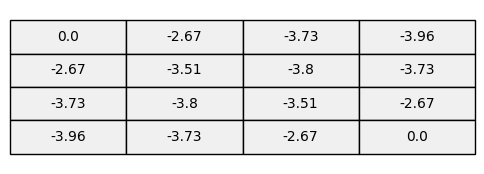

Value function at iteration 50:


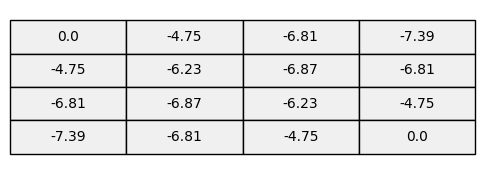

Value function at iteration 99:


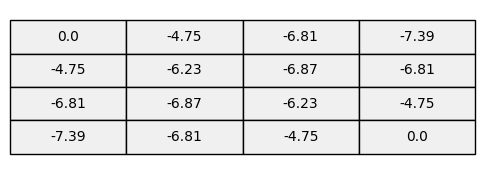

In [81]:
grid_size = (4, 4)
gamma = 0.9
policy = np.ones((4, 4, 4)) * 0.25  # Equal probability for each action in every state

values_over_iterations = iterative_policy_eval(policy, grid_size, gamma, max_iterations=100)

print("Value function at iteration 0:")
draw_grid(values_over_iterations[0])
print("Value function at iteration 5:")
draw_grid(values_over_iterations[5])
print("Value function at iteration 50:")
draw_grid(values_over_iterations[50])
print("Value function at iteration 99:")
draw_grid(values_over_iterations[-1])